# Week 9a: Matrix Formulation of PDE Schemes
# FTCS Diffusion

---

## Overview

In this notebook, we will explore **two equivalent approaches** to solving the 1D diffusion equation:

1. **Explicit Scheme (FTCS)**: Using the Forward Time, Centered Space approximation with iterative updates
2. **Matrix Formulation**: Reformulating the explicit scheme using matrix-vector multiplication

Both methods will produce identical results when properly implemented under stable conditions.

---
## 1. The 1D Diffusion Equation

### Physical Problem

Consider a metal bar of thermal conductivity $\kappa$. If $T(x,t)$ is the temperature at position $x$ and time $t$, the time evolution of temperature is governed by the **diffusion equation**:

$$\frac{\partial T(x,t)}{\partial t} = \kappa \frac{\partial^2 T(x,t)}{\partial x^2}$$

From an initial condition at $t=0$, we must integrate the temperature forward in time subject to boundary conditions at the ends of the bar.

---
## 2. Discretization: The FTCS Scheme

### Spatial and Temporal Discretization

We discretize space into $N$ points with spacing $h$ and time into steps with spacing $\tau$.

Let $T_i^n = T(x_i, t_n)$ denote the temperature at:
- Spatial position: $x_i = ih$ (where $i = 0, 1, 2, ..., N-1$)
- Time: $t_n = n\tau$ (where $n = 0, 1, 2, ..., M-1$)

### The FTCS Update Formula

Using the **Forward Time, Centered Space** (FTCS) finite difference approximation:

$$T_i^{n+1} = T_i^n + \frac{\kappa \tau}{h^2}\left(T_{i+1}^n + T_{i-1}^n - 2T_i^n\right)$$

where the coefficient is:

$$\text{coeff} = \frac{\kappa \tau}{h^2}$$

### Stability Criterion

For stability, we need:

$$\frac{\tau}{2t_\sigma} = \frac{\kappa \tau}{2h^2} < 1$$

where $t_\sigma = \frac{h^2}{\kappa}$ is the characteristic diffusion time scale.

**This means:** $\tau < \frac{h^2}{\kappa}$ for stable solutions (see Equation 6.28 in textbook).

---
## 3. Implementation Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Set plot parameters for better visualization
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

---
## 4. Method 1: Explicit FTCS Scheme (Loop-Based)

### Implementation Details

This function implements the FTCS scheme by:
1. Setting up a spatial grid with $N$ points
2. Setting up a temporal grid with $M$ time steps
3. Applying a **delta function** as the initial condition at the center
4. **Iteratively** solving for $T(x,t)$ using the FTCS update formula

### Boundary Conditions

We use **Dirichlet boundary conditions**: $T_0^n = T_{N-1}^n = 0$ (fixed temperature at boundaries)

In [2]:
def diffusion_ftcs(nspace, ntime, tau_rel, args=[1.0, 1.0]):
    """ 
    Compute the solution to the diffusion equation using the 
    forward-time, centered-space (FTCS) algorithm
    
    Parameters:
    -----------
    nspace : int
        Number of spatial grid points
    ntime : int
        Number of time steps
    tau_rel : float
        Time step in units of t_sigma = h²/κ
    args : list
        [L, kappa] where L is domain length and kappa is diffusion coefficient
        
    Returns:
    --------
    tt : ndarray (nspace × ntime)
        Temperature T(x,t) at all grid points and times
    """
    # Check stability condition
    if tau_rel < 1.0:
        print('✓ Solution is expected to be STABLE')
    else:
        print('⚠ WARNING: Solution is expected to be UNSTABLE')
        
    L = args[0]              # System extends from x = -L/2 to x = L/2
    kappa = args[1]          # Diffusion coefficient
    h = L / (nspace - 1)     # Grid spacing
    t_sigma = h**2 / (2 * kappa)  # Critical time scale
    tau = tau_rel * t_sigma       # Actual time step
    coeff = kappa * tau / h**2    # FTCS coefficient

    # Set initial and boundary conditions
    tt = np.zeros((nspace, ntime))    # Initialize temperature to zero
    tt[int(nspace/2), 0] = 1.0 / h    # Initial condition: delta function at center
    # Boundary conditions: tt[0, :] = tt[N-1, :] = 0 (implicitly zero)

    # MAIN LOOP: Time stepping
    for istep in range(1, ntime):
        # Compute new temperature using FTCS scheme
        # T_i^(n+1) = T_i^n + coeff * (T_(i+1)^n + T_(i-1)^n - 2*T_i^n)
        tt[1:(nspace-1), istep] = (tt[1:(nspace-1), istep-1] + 
            coeff * (tt[2:nspace, istep-1] + tt[0:(nspace-2), istep-1] - 
                     2 * tt[1:(nspace-1), istep-1]))
        
    return tt

---
## 5. Method 2: Matrix Formulation of FTCS

### Mathematical Reformulation

We can write the FTCS update as a **matrix equation**:

$$\mathbf{T}^{n+1} = \mathbf{T}^n + \frac{\kappa\tau}{h^2}\mathbf{D}\mathbf{T}^n$$

or equivalently:

$$\mathbf{T}^{n+1} = \mathbf{A}\mathbf{T}^n$$

where:

$$\mathbf{A} = \mathbf{I} + \frac{\kappa\tau}{h^2}\mathbf{D}$$

### The Diffusion Matrix D

The matrix $\mathbf{D}$ implements the discrete second derivative operator:

$$\mathbf{D} = \begin{bmatrix}
-2 & 1 & 0 & \cdots & 0 \\
1 & -2 & 1 & \cdots & 0 \\
0 & 1 & -2 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & -2
\end{bmatrix}$$

**Matrix structure:**
- **Diagonal**: -2 (coefficient for $T_i^n$)
- **Super-diagonal**: +1 (coefficient for $T_{i+1}^n$)
- **Sub-diagonal**: +1 (coefficient for $T_{i-1}^n$)
- **All other entries**: 0

### Boundary Conditions in Matrix Form

**1. Dirichlet Boundary Conditions:** $T_0^n, T_{N-1}^n = \text{const}$

Implementation: Set rows 0 and $N-1$ of matrix $\mathbf{D}$ to all zeros.

**2. Periodic Boundary Conditions:** $T_0^n = T_{N-1}^n$

Implementation: Set off-diagonal corners of $\mathbf{D}$ to 1:
- $D_{0, N-1} = 1$
- $D_{N-1, 0} = 1$

In [3]:
def diffusion_ftcs_mtx(nspace, ntime, tau_rel, args=[1.0, 1.0]):
    """ 
    Compute the solution to the diffusion equation using the 
    forward-time, centered-space algorithm in MATRIX FORMULATION
    
    Parameters:
    -----------
    nspace : int
        Number of spatial grid points
    ntime : int
        Number of time steps
    tau_rel : float
        Time step in units of t_sigma = h²/κ
    args : list
        [L, kappa] where L is domain length and kappa is diffusion coefficient
        
    Returns:
    --------
    tt : ndarray (nspace × ntime)
        Temperature T(x,t) at all grid points and times
    """
    # Check stability condition
    if tau_rel < 1.0:
        print('✓ Solution is expected to be STABLE')
    else:
        print('⚠ WARNING: Solution is expected to be UNSTABLE')
        
    L = args[0]              # System extends from x = -L/2 to x = L/2
    kappa = args[1]          # Diffusion coefficient
    h = L / (nspace - 1)     # Grid spacing
    t_sigma = h**2 / (2 * kappa)  # Critical time scale
    tau = tau_rel * t_sigma       # Actual time step
    coeff = kappa * tau / h**2    # FTCS coefficient

    # Set initial and boundary conditions
    tt = np.zeros((nspace, ntime))    # Initialize temperature to zero
    tt[int(nspace/2), 0] = 1.0 / h    # Initial condition: delta function at center

    # Construct diffusion matrix D (NM4P p222)
    # Start with tridiagonal structure: -2 on diagonal, +1 on off-diagonals
    D = -2 * np.identity(nspace) + \
        np.diagflat(np.ones(nspace-1), 1) + \
        np.diagflat(np.ones(nspace-1), -1)
    
    # Apply Dirichlet boundary conditions: T[0] = T[N-1] = 0
    D[0] = 0      # First row all zeros
    D[-1] = 0     # Last row all zeros
    
    # Construct the update matrix A = I + coeff*D
    A = np.identity(nspace) + coeff * D
    
    # MAIN LOOP: Time stepping using matrix multiplication
    for istep in range(1, ntime):
        # Matrix formulation: T^(n+1) = A · T^n
        tt[:, istep] = A.dot(tt[:, istep-1])
        
    return tt

---
## 6. Stability Analysis via Eigenvalues

### Theoretical Background

Since we can write:

$$\mathbf{T}^{n+1} = \mathbf{A}^n \mathbf{T}^1$$

If we express $\mathbf{T}$ in terms of the eigenvectors of $\mathbf{A}$ (see equations 9.15-9.18 in textbook):

$$\mathbf{T}^n = \sum_k c_k \lambda_k^n \mathbf{v}_k$$

where $\lambda_k$ are eigenvalues and $\mathbf{v}_k$ are eigenvectors of $\mathbf{A}$.

### Stability Criterion

Multiplying $\mathbf{T}$ by $\mathbf{A}$ $n$ times involves multiplying by eigenvalues $n$ times, or $(\lambda_k)^n$.

**For stability:** We need $|\lambda_k| \leq 1$ for all eigenvalues.

**If $|\lambda_k| > 1$:** The solution diverges → **unstable**!

---
## 7. Numerical Experiments

### Setup Parameters

Let's solve the diffusion equation with the following parameters:
- Domain: $x \in [-0.5, 0.5]$ (so $L = 1.0$)
- Spatial points: $N = 61$
- Grid spacing: $h = L/(N-1) = 1/60$
- Diffusion coefficient: $\kappa = 1.0$
- Time steps: $M = 300$
- Relative time step: ensures stability

In [4]:
# Physical parameters
L = 1.0          # Domain length
kappa = 1.0      # Diffusion coefficient
nspace = 61      # Number of spatial points
ntime = 300      # Number of time steps

# Compute grid spacing
h = L / (nspace - 1)
print(f"Grid spacing: h = {h:.6f}")

# Compute characteristic time scale
t_sigma = h**2 / (2 * kappa)
print(f"Characteristic time: t_σ = {t_sigma:.6f}")

# Choose time step (must be < t_sigma for stability)
tau = 1e-4
tau_rel = tau / t_sigma
print(f"Relative time step: τ/t_σ = {tau_rel:.6f}")
print(f"Stability check: τ_rel < 1.0? {tau_rel < 1.0}")

Grid spacing: h = 0.016667
Characteristic time: t_σ = 0.000139
Relative time step: τ/t_σ = 0.720000
Stability check: τ_rel < 1.0? True


### Run Both Simulations

In [5]:
print("\n" + "="*60)
print("Running EXPLICIT FTCS (loop-based)...")
print("="*60)
tt = diffusion_ftcs(nspace, ntime, tau_rel, args=[L, kappa])

print("\n" + "="*60)
print("Running MATRIX FORMULATION...")
print("="*60)
tt_mtx = diffusion_ftcs_mtx(nspace, ntime, tau_rel, args=[L, kappa])

# Create spatial and temporal grids for plotting
xplot = np.arange(nspace) * h - 0.5
tplot = np.arange(ntime) * tau


Running EXPLICIT FTCS (loop-based)...
✓ Solution is expected to be STABLE

Running MATRIX FORMULATION...
✓ Solution is expected to be STABLE


---
## 8. Verification: Comparing Both Methods

### Method Comparison

Both methods should produce **identical results** if implemented correctly under stable conditions.

Let's verify this by computing the difference between the two solutions:

In [6]:
# Compute differences
diff_sum = (tt - tt_mtx).sum()
diff_abs_sum = np.abs(tt - tt_mtx).sum()
diff_max = np.abs(tt - tt_mtx).max()

print("\n" + "="*60)
print("VERIFICATION: Comparing Explicit vs Matrix Methods")
print("="*60)
print(f"Sum of differences:              {diff_sum:.2e}")
print(f"Sum of absolute differences:     {diff_abs_sum:.2e}")
print(f"Maximum absolute difference:     {diff_max:.2e}")
print("\n✓ Methods agree to numerical precision!" if diff_max < 1e-10 else "✗ Significant difference found!")


VERIFICATION: Comparing Explicit vs Matrix Methods
Sum of differences:              5.06e-12
Sum of absolute differences:     5.20e-12
Maximum absolute difference:     3.55e-15

✓ Methods agree to numerical precision!


---
## 9. Visualization

### Plotting Function

We'll visualize the diffusion process using both 3D surface plots and 2D contour plots.

In [7]:
def doplot(xplot, tplot, tt, ptype, title_suffix=""):
    """
    Visualize the diffusion solution
    
    Parameters:
    -----------
    xplot : array
        Spatial coordinates
    tplot : array
        Time coordinates
    tt : array
        Temperature field T(x,t)
    ptype : str
        Plot type: 'mesh' for 3D surface, 'contour' for 2D contours
    title_suffix : str
        Additional text for plot title
    """
    fig = plt.figure(figsize=(12, 8))
    
    if ptype == 'mesh':
        ax = fig.add_subplot(projection='3d')
        Tp, Xp = np.meshgrid(tplot, xplot)
        ax.plot_surface(Tp, Xp, tt, rstride=2, cstride=2, cmap=cm.viridis)
        ax.set_xlabel('Time', fontsize=12)
        ax.set_ylabel('Position x', fontsize=12)
        ax.set_zlabel('Temperature T(x,t)', fontsize=12)
        ax.set_title(f'Diffusion of a Delta Spike {title_suffix}', fontsize=14, fontweight='bold')
        
    elif ptype == 'contour':
        levels = np.linspace(0., tt.max(), num=21) 
        ct = plt.contour(tplot, xplot, tt, levels, cmap='viridis') 
        plt.clabel(ct, fmt='%1.2f', fontsize=9) 
        plt.xlabel('Time', fontsize=12)
        plt.ylabel('Position x', fontsize=12)
        plt.title(f'Temperature Contour Plot {title_suffix}', fontsize=14, fontweight='bold')
        #plt.colorbar(ct, label='Temperature')
        plt.grid(True, alpha=0.3)
        
    plt.tight_layout()
    plt.show()
    return

### 3D Surface Plots

These plots show the complete evolution of temperature $T(x,t)$ over space and time.


3D SURFACE PLOTS


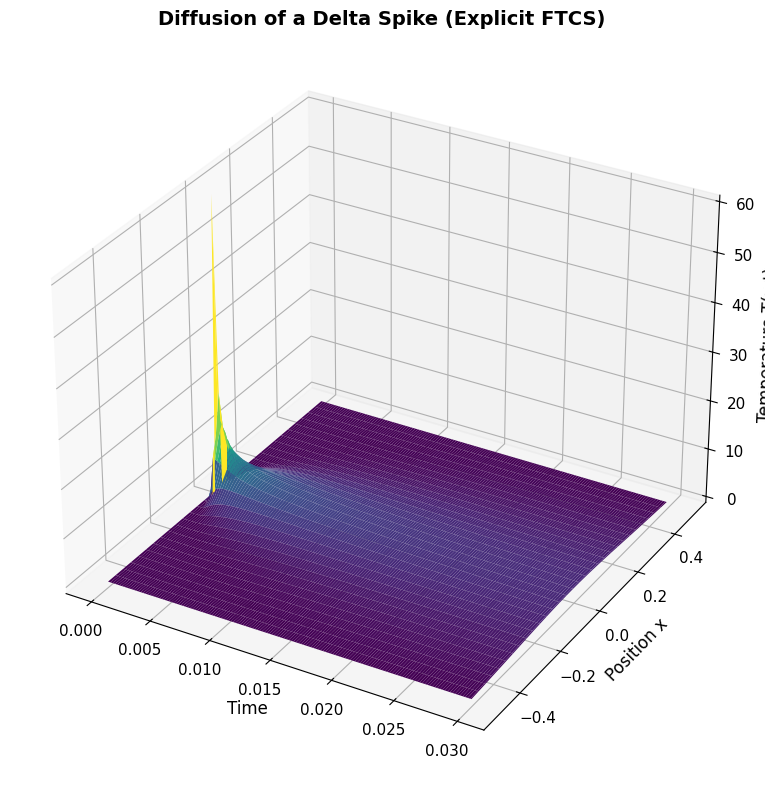

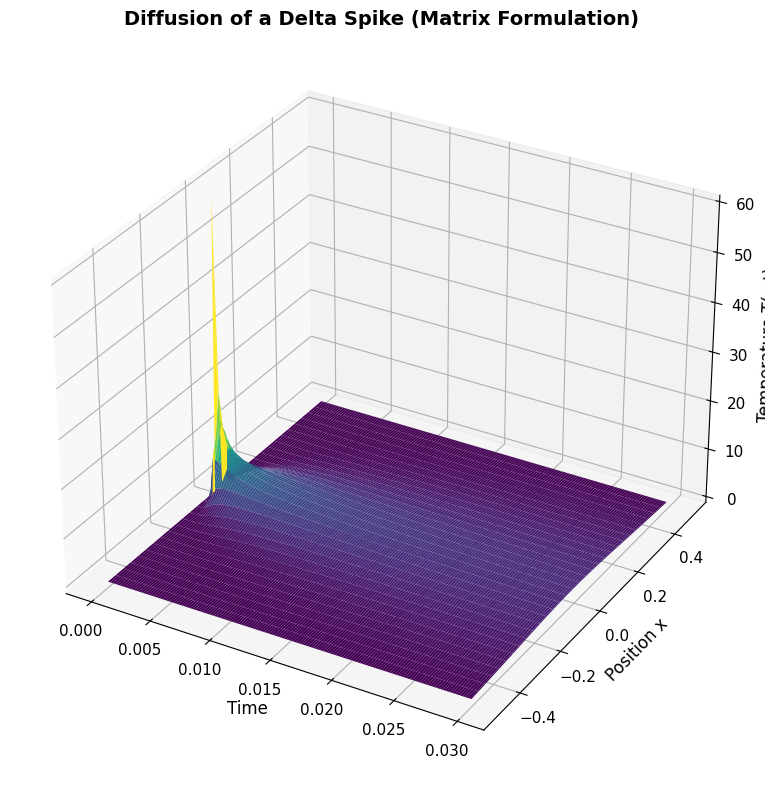

In [8]:
print("\n3D SURFACE PLOTS")
print("="*60)
doplot(xplot, tplot, tt, 'mesh', '(Explicit FTCS)')
doplot(xplot, tplot, tt_mtx, 'mesh', '(Matrix Formulation)')

### 2D Contour Plots

Contour plots provide an alternative view showing lines of constant temperature.


2D CONTOUR PLOTS


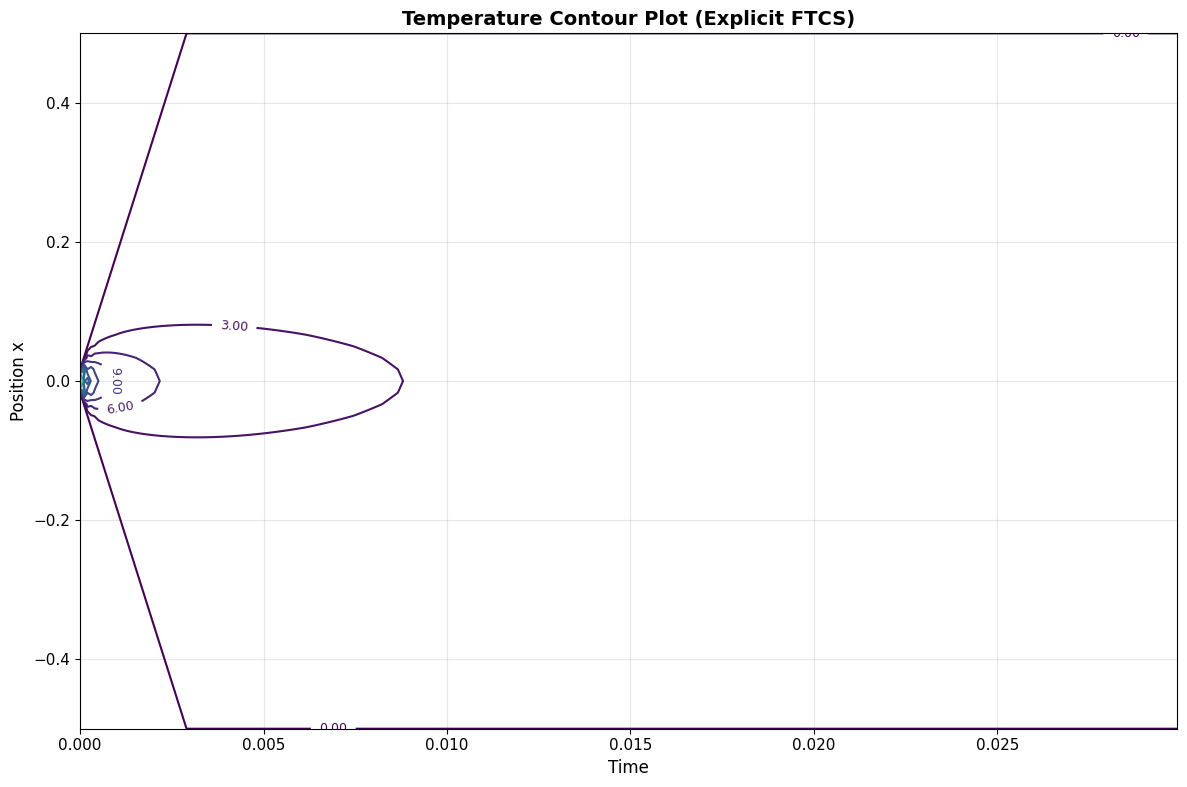

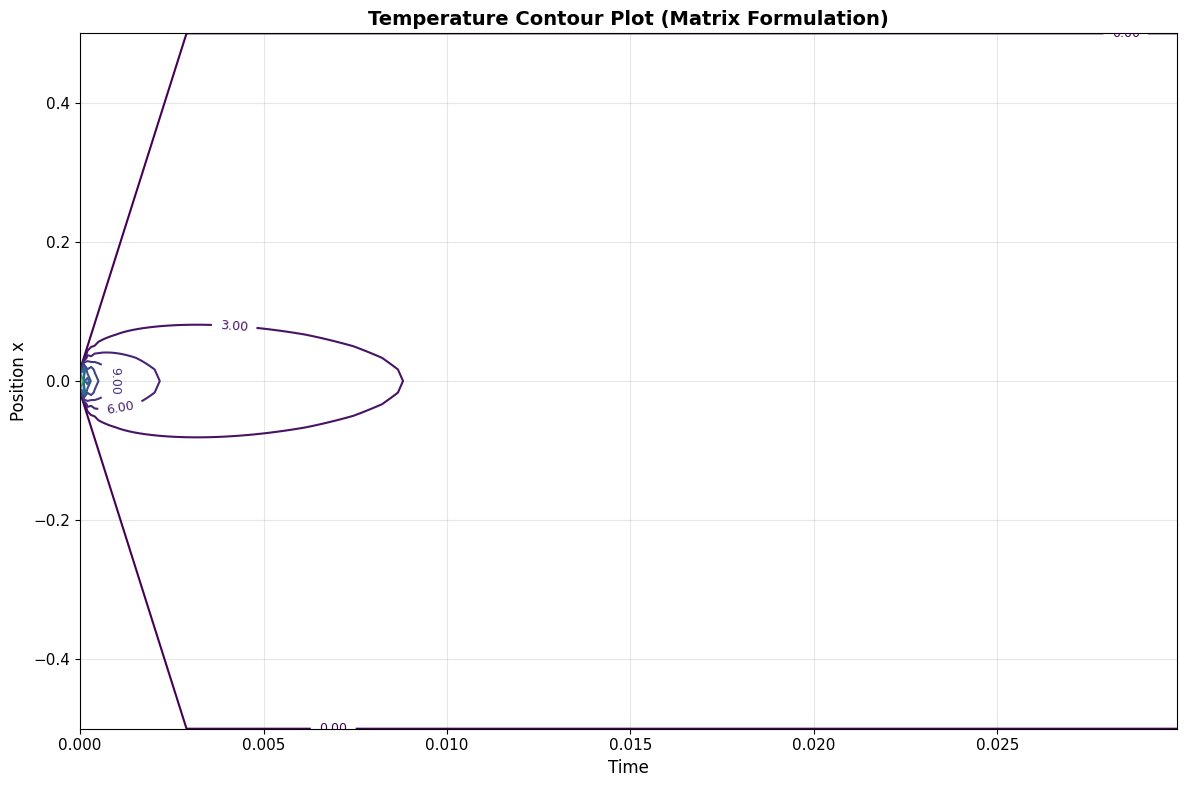

In [9]:
print("\n2D CONTOUR PLOTS")
print("="*60)
doplot(xplot, tplot, tt, 'contour', '(Explicit FTCS)')
doplot(xplot, tplot, tt_mtx, 'contour', '(Matrix Formulation)')

---
## 10. Physical Interpretation

### What We're Seeing

1. **Initial Condition (t=0)**: A sharp temperature spike (delta function) at the center of the bar

2. **Evolution**: The spike spreads out (diffuses) over time according to the diffusion equation

3. **Boundary Conditions**: Temperature remains zero at both ends of the bar (Dirichlet BCs)

4. **Long-Time Behavior**: The temperature eventually approaches zero everywhere as heat spreads out and is lost at the boundaries

### Observations

- The **peak temperature decreases** over time (conservation of total heat)
- The **width of the temperature distribution increases** (diffusion spreading)
- The process is **irreversible** (entropy increases)
- Both methods produce **identical** results, confirming our implementation

---
## 11. Summary and Key Takeaways

### FTCS Explicit vs. Matrix Formulation

1. **Both methods yield identical results** if implemented correctly under stable conditions

2. **Matrix formulation offers:**
   - Compact, efficient alternative to explicit loops
   - Better theoretical insight through eigenvalue analysis
   - Easier extension to more complex boundary conditions

3. **Stability is crucial:**
   - Must satisfy $\tau_{\text{rel}} < 1.0$
   - Eigenvalues of update matrix $\mathbf{A}$ must satisfy $|\lambda_k| \leq 1$

4. **Applications:** 
   - Heat conduction
   - Diffusion processes
   - Other phenomena governed by parabolic PDEs


---
## 12. Explore Different Parameters

Try modifying the parameters below to see how they affect the solution:

In [10]:
# EXPERIMENT: Try different parameters
# WARNING: tau_rel >= 1.0 will produce unstable results!

# Example: Higher diffusion coefficient (faster spreading)
# tt_fast = diffusion_ftcs_mtx(61, 300, 0.5, args=[1.0, 2.0])

# Example: More grid points (better spatial resolution)
# tt_fine = diffusion_ftcs_mtx(121, 300, 0.5, args=[1.0, 1.0])

# Example: Longer simulation time
# tt_long = diffusion_ftcs_mtx(61, 600, 0.5, args=[1.0, 1.0])